# Import libraries #

In [100]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

# Load Data #

In [101]:
# Directories
base_dir = "/Users/fabianwindhagen/code/nachmz42/raw_data/chest_xray"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# image preprocessing #

In [103]:
# Image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,         # Randomly zoom inside pictures
    fill_mode='nearest'     # Strategy used for filling in newly created pixels
)


val_datagen = ImageDataGenerator(rescale=1./255)

Found 5216 images belonging to 2 classes.


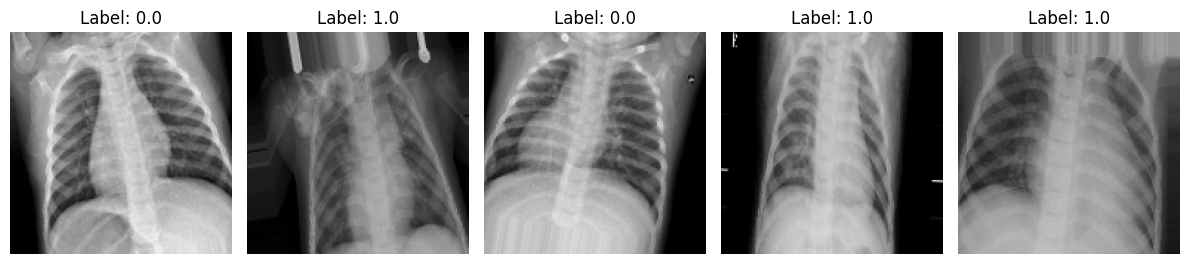

In [104]:
def visualize_augmented_images(train_datagen, directory, target_size=(150, 150), batch_size=32, num_images=5):
    # Setting up a generator with the provided datagen and directory
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  # resizing images
        batch_size=64,
        class_mode='binary')  # binary labels: pneumonia or no pneumonia
    
    # Fetching a batch of images and labels
    images, labels = next(train_generator)
    
    # Plotting the images
    plt.figure(figsize=(12, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Using the train_datagen with augmentations as discussed previously
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualizing the augmented images
visualize_augmented_images(augmented_datagen, train_dir)


In [106]:
train_generator = train_datagen.flow_from_directory(
        train_dir,# resizing images
        batch_size=64,
        class_mode='binary')  

Found 5216 images belonging to 2 classes.


In [107]:
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 16 images belonging to 2 classes.


# Now lets try to build a simple model ##

In [108]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # binary classification

In [109]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [110]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 17, 17, 128)      

## Train the model ###

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping])

Epoch 1/30
81/81 [==============================] - 324s 4s/step - loss: 0.5638 - accuracy: 0.7428
Epoch 2/30
81/81 [==============================] - 322s 4s/step - loss: 0.4533 - accuracy: 0.7694
Epoch 3/30
81/81 [==============================] - 323s 4s/step - loss: 0.4066 - accuracy: 0.8119
Epoch 4/30
81/81 [==============================] - 316s 4s/step - loss: 0.3551 - accuracy: 0.8430
Epoch 5/30
81/81 [==============================] - 308s 4s/step - loss: 0.3448 - accuracy: 0.8447
Epoch 6/30
81/81 [==============================] - 308s 4s/step - loss: 0.3075 - accuracy: 0.8612
Epoch 7/30
81/81 [==============================] - 312s 4s/step - loss: 0.3060 - accuracy: 0.8612
Epoch 8/30
81/81 [==============================] - 312s 4s/step - loss: 0.2923 - accuracy: 0.8700
Epoch 9/30
81/81 [==============================] - 307s 4s/step - loss: 0.3080 - accuracy: 0.8622
Epoch 10/30
81/81 [==============================] - 310s 4s/step - loss: 0.2950 - accuracy: 0.8680
Epoch 11/

In [112]:
history.history.keys()


dict_keys(['loss', 'accuracy'])

## Test the model ###

In [113]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary')

Found 624 images belonging to 2 classes.


## evaluate ####

In [114]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Test accuracy:", accuracy)

9/9 [==============================] - 10s 1s/step - loss: 0.4174 - accuracy: 0.8177
Test accuracy: 0.8177083134651184


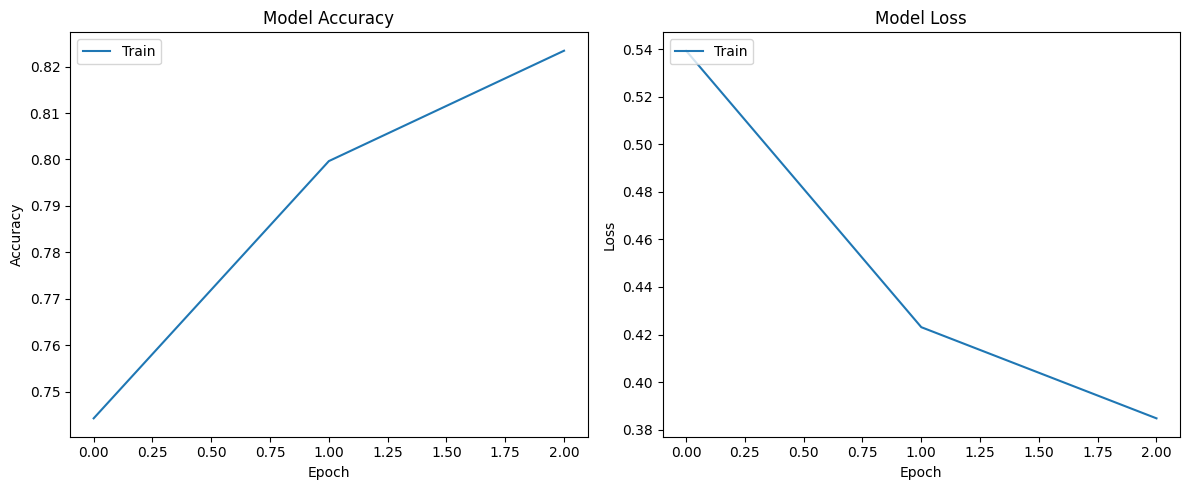

In [81]:
# visualize loss and training accuracy 

def plot_training_history(history):
    # Plot training accuracy values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    # Plot training loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


plot_training_history(history)

